In [3]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [4]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import seaborn as sns 
from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [6]:
from scipy.stats import kendalltau as kt
import numpy as np
import scipy.spatial.distance


In [7]:
from master_analysis import *

In [8]:
exps = pd.read_hdf(r'/home/nataliam/swdb_2017_tools/projects/mouseRSA/exps_w_RSA_wrunning.h5',mode='r')


In [9]:
exps.loc[(exps.imaging_depth>100) & (exps.imaging_depth<=200),'imaging_depth']=175

exps.loc[(exps.imaging_depth>300) & (exps.imaging_depth<500),'imaging_depth']=350
exps.loc[(exps.imaging_depth>200) & (exps.imaging_depth<=300),'imaging_depth']=275
exps.loc[(exps.cre_line=='Nr5a1-Cre'),'imaging_depth']=275

In [18]:
clusters = pd.read_hdf('final_cluster_bools.h5',key='clusters')
coms = pd.read_hdf('RF_COMs.h5')

In [58]:
#rfs = get_rfs(exps_wrunning)

In [14]:
cluster1 = clusters.loc[0].values

/opt/conda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


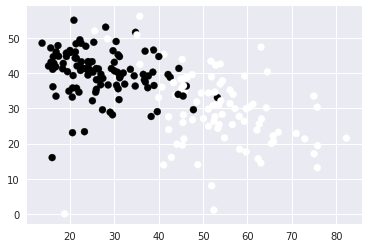

In [19]:
plt.scatter(coms[1],coms[0],c=cluster1)

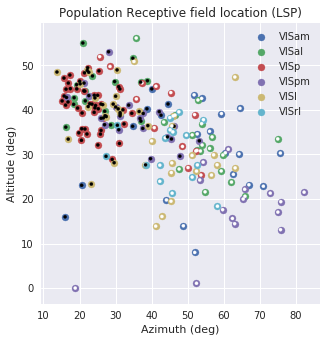

In [21]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = exps.targeted_structure[:len(coms)]
y,x = np.array(coms[0]),np.array(coms[1])

for area in areas.unique():
    plt.scatter(
        x[(areas==area).values], y[(areas==area).values], marker = 'o'
        )

plt.legend(areas.unique())
plt.scatter(coms[1],coms[0],c=cluster1,s=10)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
plt.xticks()
plt.title('Population Receptive field location (LSP)')

### Now compare

In [22]:
# within area RSM comparisons 

In [23]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_cre_lines()
targeted_structures=boc.get_all_targeted_structures()
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [25]:
exps_grouped=get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = cluster1,
                                     rsm_selection='mean')


In [26]:
kt_all = get_all_kt_matrix(exps_grouped)
kt_all = kt_all.sort_index(axis=0).sort_index(axis=1)


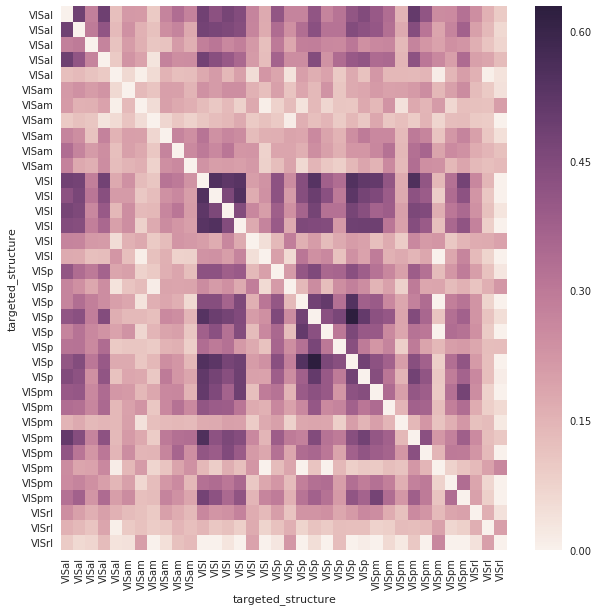

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(kt_all,vmin=0)


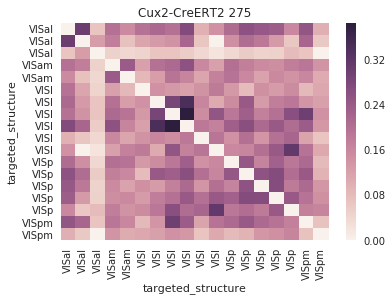

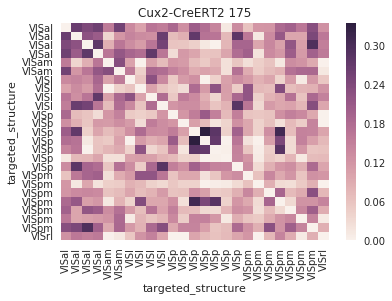

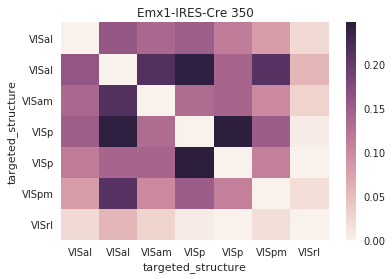

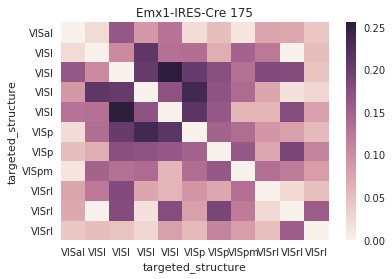

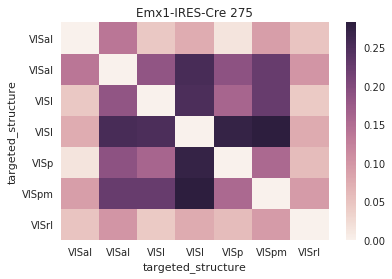

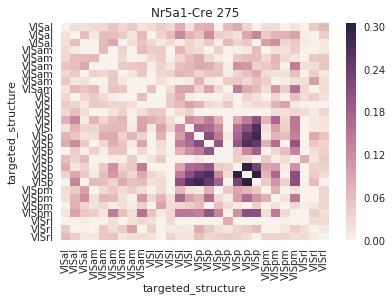

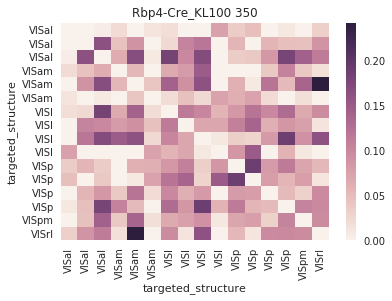

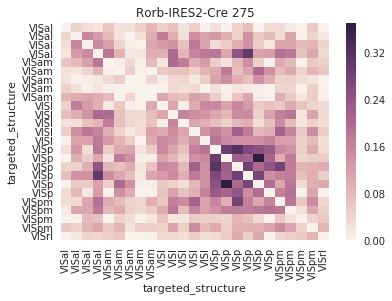

In [224]:
kt_dfs=get_kt_matrix(just_nonzeros,'targeted_structure')

In [ ]:
# to do: modify get_experiments_grouped so that it takes into account the valid_stimuli columns

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA

In [ ]:
def get_unfolded_rsm(exps_grouped):
    """Takes the result of get_experiments_grouped and performs a 2D embedding on the rsms.
    Output: 2D numpy array of length number_experiments"""
    n_stim = exps_grouped.loc[0,'rsm'].shape[0]
    matrix_to_embed = np.vstack(
                        exps_grouped.rsm.apply( # apply this function to each rsm
                                scipy.spatial.distance.squareform))
        
    return matrix_to_embed

In [ ]:
def scatter_viz(to_plot,exps_grouped):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.subplots_adjust(bottom = 0.1)

    areas = exps_grouped.targeted_structure
    
    for area in areas.unique():

        plt.scatter(
            to_plot[areas.values==area, 0], to_plot[areas.values==area, 1], marker = 'o'
            )

    plt.legend(areas.unique())

In [ ]:
to_embed = get_unfolded_rsm(exps_grouped)

Reduce dimensions with PCA then run tsne

In [ ]:
se = SpectralEmbedding(n_components = 10)
se_rsm = se.fit_transform(to_embed)

In [ ]:
tsne = TSNE(perplexity=5.0,metric=)
to_plot = tsne.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = LocallyLinearEmbedding(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = SpectralEmbedding(n_components=3)
to_plot = method.fit_transform(to_embed)

pca = PCA(n_components=2, whiten=False)
to_plot = pca.fit_transform(to_plot)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = PCA(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = MDS(n_components=2,eps = 1e-1)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

Or let's try to visualize the kts with MDS

In [184]:
kt_df = kt_dfs[-1]
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_df.values)
to_plot = results.embedding_

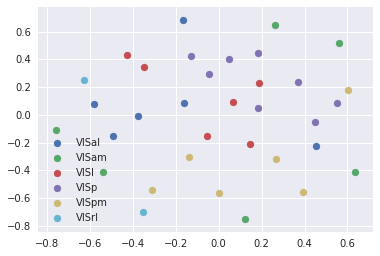

In [440]:

plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_df.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [441]:

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_all.values)
to_plot = results.embedding_

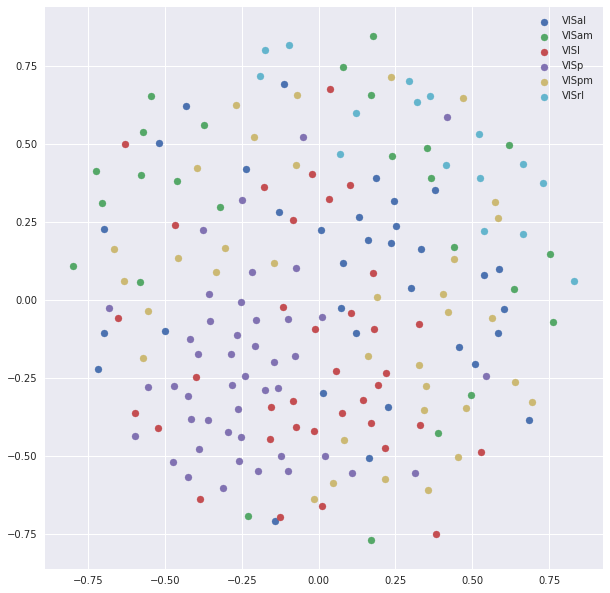

In [445]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_all.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [446]:
exps_grouped.head()

,cre_line,imaging_depth,targeted_structure,rsm
0,Cux2-CreERT2,275,VISal,"[[0.0, 14.0271879134, 17.7364615024, 17.471313..."
1,Cux2-CreERT2,275,VISal,"[[0.0, 19.7863268783, 24.5694978749, 20.453725..."
2,Cux2-CreERT2,275,VISal,"[[0.0, 10.065717023, 10.2442107709, 10.3606364..."
3,Cux2-CreERT2,275,VISal,"[[0.0, 19.5142452541, 20.1135017267, 20.266742..."
4,Cux2-CreERT2,275,VISal,"[[0.0, 12.7419734687, 12.0693315323, 11.451070..."


In [ ]:
exps_grouped['targeted_structure'].unique()

In [ ]:
available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
available_targeted_structures

In [ ]:
for cre_line in cre_lines
sns.heatmap(kt_df)
plt.title(cre_lines+imaging_depths)

In [ ]:
np.fill_diagonal(kt_matrix,0)
sns.heatmap(kt_matrix)

In [ ]:
rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsm.mean()

In [ ]:
to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])

In [ ]:
exps_grouped=exps_grouped.append(to_add.T)

In [ ]:
exps_grouped.head()